# Pitch Quality by Pitch Type

# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Analysis](#Analysis)
    - [Run Value by Event](#Run-Value-for-Ball-in-Play-by-Events)
    - [Run Value by Count](#Run-Value-by-Count)
    - [Avg Run Value by Pitch Type](#Average-Run-Value-by-Pitch-Type)
- [4-Seam Analysis](#4-Seam-Analysis)
    - [Top 10 4-Seam xQual](#Top-10-4-Seam-xQual)
    - [4-Seam HB & VB](#4-Seam-HB-&-VB)
- [Cutter Analysis](#Cutter-Analysis)
    - [Top 10 Cutter xQual](#Top-10-Cutter-xQual)
    - [Cutter HB & VB](#Cutter-HB-&-VB)
- [Sinker Analysis](#Sinker-Analysis)
    - [Top 10 Sinker xQual](#Top-10-Sinker-xQual)
    - [Sinker HB & VB](#Sinker-HB-&-VB)
- [Slider Analysis](#Slider-Analysis)
    - [Top 10 Slider xQual](#Top-10-Slider-xQual)
    - [Slider HB & VB](#Slider-HB-&-VB)
- [Curveball Analysis](#Curveball-Analysis)
    - [Top 10 Curveball xQual](#Top-10-Curveball-xQual)
    - [Curveball HB & VB](#Curveball-HB-&-VB)
- [Changeup Analysis](#Changeup-Analysis)
    - [Top 10 Changeup xQual](#Top-10-Changeup-xQual)
    - [Changeup HB & VB](#Changeup-HB-&-VB)

# Imports

In [1]:
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.patches import Rectangle
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

xrv = pd.read_csv('../data/xrv-pitches.csv', index_col = [0])
rv_pitches = pd.read_csv('../data/pitches-rv-table.csv', index_col = [0])
xrv_grouped = pd.read_csv('../data/xrv_grouped.csv', index_col = [0])

pd.set_option('max_columns', None)
print(xrv.shape)
xrv.head()

(680883, 15)


,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,slot,release_extension,rv,n_pitches,xRV
0,"Gsellman, Robert",R,FF,93.4,1999.0,8.16,10.68,1.71,5.85,28.8,1,6.3,0.017,1,0.01969
1,"Martin, Chris",R,FF,95.3,2252.0,3.24,13.56,2.58,6.42,40.1,3,6.7,-0.053,1,0.03446
2,"Martin, Chris",R,FF,94.9,2224.0,9.00,14.16,2.71,6.38,40.1,3,6.6,-0.214,1,-0.12472
3,"Hembree, Heath",R,FF,93.5,2419.0,12.12,17.28,0.45,5.87,20.1,1,6.7,-0.245,1,-0.14789
4,"Hembree, Heath",R,FF,95.5,2516.0,12.48,18.24,0.55,5.91,20.1,1,6.6,-0.034,1,0.01774


In [3]:
print(rv_pitches.shape)
rv_pitches.head()

(3346, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,arm_angle,slot,release_extension,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207.0,92.6,9.6,17.2,43.3,2.0,6.2,4.3,2.1,4.3,2.1
1,"Abreu, Albert",R,FF,103.0,97.8,11.7,15.4,40.8,3.0,6.4,-2.4,-2.3,-3.2,-3.1
2,"Abreu, Bryan",R,FF,310.0,95.7,8.0,17.1,28.7,1.0,6.3,-4.1,-1.3,-7.4,-2.4
3,"Acevedo, Domingo",R,FF,88.0,92.9,12.2,15.1,31.0,1.0,5.8,1.6,1.8,1.4,1.6
4,"Adam, Jason",R,FF,125.0,93.8,7.0,16.8,34.5,1.0,6.7,1.8,1.4,-2.1,-1.7


In [4]:
print(xrv_grouped.shape)
xrv_grouped.head()

(705396, 20)


,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,FF_count,SI_count,FC_count,xRV,CU_count,SL_count,KC_count,CH_count,FS_count
0,"Gsellman, Robert",R,SI,94.3,1982.0,16.20,10.56,1.20,6.05,6.5,-0.245,0.0,1.0,0.0,-0.18110,0.0,0.0,0.0,0.0,0.0
1,"Gsellman, Robert",R,SI,94.3,1930.0,18.24,5.88,1.29,6.02,6.4,-0.047,0.0,1.0,0.0,-0.07872,0.0,0.0,0.0,0.0,0.0
2,"Gsellman, Robert",R,SI,94.2,2102.0,17.04,6.36,1.41,5.88,6.4,-0.034,0.0,1.0,0.0,-0.03703,0.0,0.0,0.0,0.0,0.0
3,"Gsellman, Robert",R,SI,94.1,2033.0,15.36,4.32,1.31,5.96,6.4,-0.135,0.0,1.0,0.0,-0.04820,0.0,0.0,0.0,0.0,0.0
4,"Gsellman, Robert",R,SI,93.6,2019.0,15.48,6.96,1.42,5.89,6.5,-0.135,0.0,1.0,0.0,-0.06808,0.0,0.0,0.0,0.0,0.0


# Preprocessing

In [5]:
ff = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FF') & (rv_pitches['n_pitches'] > 100)]
fc = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FC') & (rv_pitches['n_pitches'] > 100)]
si = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SI') & (rv_pitches['n_pitches'] > 100)]
sl = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SL') & (rv_pitches['n_pitches'] > 100)]
cu = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CU') & (rv_pitches['n_pitches'] > 100)]
ch = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CH') & (rv_pitches['n_pitches'] > 100)]

ff_stats = xrv.loc[xrv['pitch_type'] == 'FF']
fc_stats = xrv.loc[xrv['pitch_type'] == 'FC']
si_stats = xrv.loc[xrv['pitch_type'] == 'SI']
sl_stats = xrv.loc[xrv['pitch_type'] == 'SL']
cu_stats = xrv.loc[xrv['pitch_type'] == 'CU']
ch_stats = xrv.loc[xrv['pitch_type'] == 'CH']

#fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'FC', 'SI'])]
#bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'CU', 'KC'])]
#os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS'])]

### Multicolinearity - VIF

**Independent Variables:** Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

**Dependent Variable:** rv

In [6]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'arm_angle',
                 'release_extension', 'rv']]

features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

print(vif_data.sort_values(by = 'VIF'))

             feature         VIF
8                 rv    1.011820
2              pfx_x    1.381995
4      release_pos_x    2.456688
3              pfx_z    3.112930
6          arm_angle    8.860496
1          spin_rate   50.640764
5      release_pos_z  127.152933
7  release_extension  162.940014
0               velo  298.874018


# Analysis

### Run Value for Ball in Play by Events

In [7]:
data.groupby(['events'], as_index = False)['re24', 'lin_weight_above_outs', 
                                           'lin_weights_above_outs_scale', 'rv'].mean()

,events,re24,lin_weight_above_outs,lin_weights_above_outs_scale,rv
0,double,0.770147,1.041,1.259,0.692604
1,field_error,0.445453,0.716,0.866,0.361452
2,field_out,-0.271404,0.000,0.000,-0.372342
3,hit_by_pitch,0.359255,0.630,0.762,0.407971
4,home_run,1.385794,1.657,2.003,1.312059
5,single,0.474625,0.746,0.902,0.393770
6,triple,1.062984,1.334,1.613,0.985045
7,walk,0.332291,0.603,0.729,0.507749


### Run Value by Count

In [8]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'rv'].mean()

,pitch_count,woba,wraa_change,rv
0,0-0,0.314,-0.009615,-0.001308
1,0-1,0.265,-0.018637,-0.011327
2,0-2,0.197,-0.067643,-0.116486
3,1-0,0.356,-0.008226,0.001337
4,1-1,0.300,-0.021004,-0.008173
...,...,...,...,...
7,2-1,0.357,-0.018046,-0.003310
8,2-2,0.269,-0.105299,-0.151159
9,3-0,0.540,0.006415,0.129337
10,3-1,0.477,-0.006323,0.110551


### Average Run Value by Pitch Type

In [9]:
xrv.groupby(['pitch_type'], as_index = False, sort = False)['rv', 'xRV'].mean()

,pitch_type,rv,xRV
0,FF,-0.024296,-0.020886
1,FC,-0.024137,-0.021908
2,SI,-0.016802,-0.014002
3,SL,-0.040556,-0.039973
4,CU,-0.038081,-0.037628
5,CH,-0.031865,-0.029683


In [10]:
rv_pitches.groupby(['pitch_type'], as_index = False, sort = False)['RV/100', 'xRV/100'].mean()

,pitch_type,RV/100,xRV/100
0,FF,-1.355417,-1.182067
1,FC,-0.715487,-1.066372
2,SI,-0.996464,-0.669941
3,SL,-2.981686,-2.996076
4,CU,-1.842949,-1.939103
5,CH,-1.850920,-1.928528


# 4-Seam Analysis

In [11]:
ff_r_stats = ff_stats.loc[ff_stats['p_throws'] == 'R']
ff_l_stats = ff_stats.loc[ff_stats['p_throws'] == 'L']

ff_r_avg = ff_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
ff_l_avg = ff_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
ff_avg = pd.concat([ff_r_avg, ff_l_avg], ignore_index = True)
ff_avg = ff_avg.round(1)
ff_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,FF,R,94.1,2283.3,7.1,16.1,5.9,6.4
1,FF,L,92.8,2249.4,-7.5,16.2,6.0,6.3


In [12]:
ff_stats[['rv', 'xRV']].describe()

,rv,xRV
count,249663.000000,249663.000000
mean,-0.024296,-0.020886
std,0.272280,0.155631
min,-1.818000,-1.199450
25%,-0.060000,-0.062540
50%,-0.034000,-0.023390
75%,0.028000,0.016490
max,3.726000,2.539170


### Top 10 4-Seam xQual

In [13]:
ff_stats['RV/100'] = ((ff_stats['rv'] / ff_stats['n_pitches']) * 100)
ff_stats['xRV/100'] = ((ff_stats['xRV'] / ff_stats['n_pitches']) * 100)

cols = list(ff_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
ff_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    ff_stats[col_zscore] = ((ff_stats[col] - ff_stats[col].mean()) / ff_stats[col].std(ddof = 0) * -1)

stats = ff_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                         as_index = False)['n_pitches', 'rv', 'xRV', 'rv_zscore', 'xRV_zscore'].sum()

ff_stats = pd.merge(ff_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
ff_stats['Qual'] = ff_stats['rv_zscore_y'] + 100
ff_stats['xQual'] = ff_stats['xRV_zscore_y'] + 100
ff_r_stats = ff_stats.loc[ff_stats['p_throws'] == 'R']
ff_l_stats = ff_stats.loc[ff_stats['p_throws'] == 'L']

q_stats = ff_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
ff_leaders = stats.sort_values(by = ['xQual'], ascending = False)
ff_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
765,"Wheeler, Zack",R,FF,1353,97.17,7.65,15.91,-63.86,-4.72,213.82,-67.63,-5.00,352.99
584,"Ray, Robbie",L,FF,1864,94.78,-8.18,17.13,-82.44,-4.42,236.43,-75.06,-4.03,332.15
137,"Cole, Gerrit",R,FF,1397,97.67,11.99,17.96,-61.21,-4.38,200.16,-62.56,-4.48,314.51
272,"Green, Chad",R,FF,853,95.69,4.47,19.32,-44.84,-5.26,188.57,-49.95,-5.86,306.50
783,"Woodruff, Brandon",R,FF,940,96.52,6.35,16.64,-54.18,-5.76,215.11,-50.29,-5.35,296.96
416,"Lynn, Lance",R,FF,1051,93.99,6.03,14.94,-49.90,-4.75,189.50,-50.51,-4.81,283.47
801,"deGrom, Jacob",R,FF,704,99.21,9.07,16.45,-40.22,-5.71,184.88,-42.19,-5.99,276.63
602,"Rodríguez, Richard",R,FF,812,93.09,13.43,15.17,-40.51,-4.99,176.34,-40.93,-5.04,254.01
642,"Scherzer, Max",R,FF,1316,94.30,10.61,16.03,-57.00,-4.33,191.92,-51.40,-3.91,253.68
605,"Rogers, Trevor",L,FF,1249,94.55,-11.07,14.80,-54.71,-4.38,189.49,-49.32,-3.95,249.25


### RHP 4-Seam HB & VB

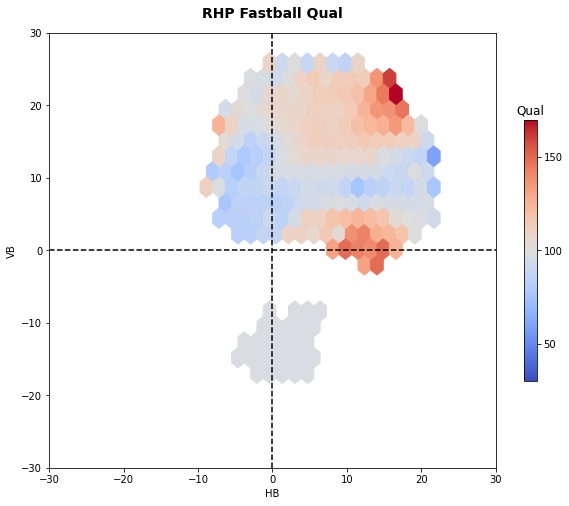

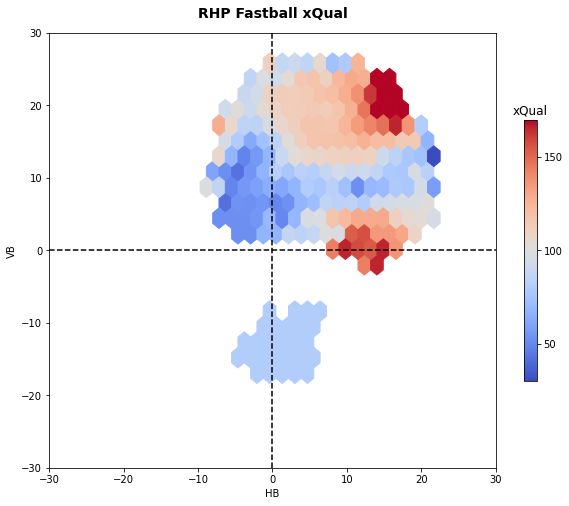

In [14]:
plt.figure(figsize = (10, 8))
plt.hexbin(ff_r_stats['pfx_x'], ff_r_stats['pfx_z'], C = ff_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(ff_r_stats['pfx_x'], ff_r_stats['pfx_z'], C = ff_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP 4-Seam HB & VB

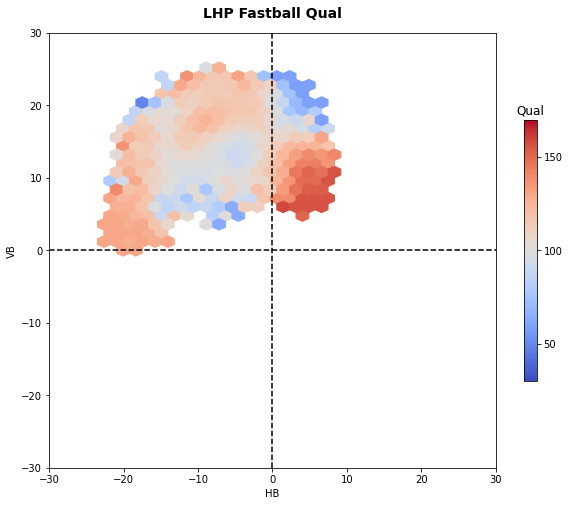

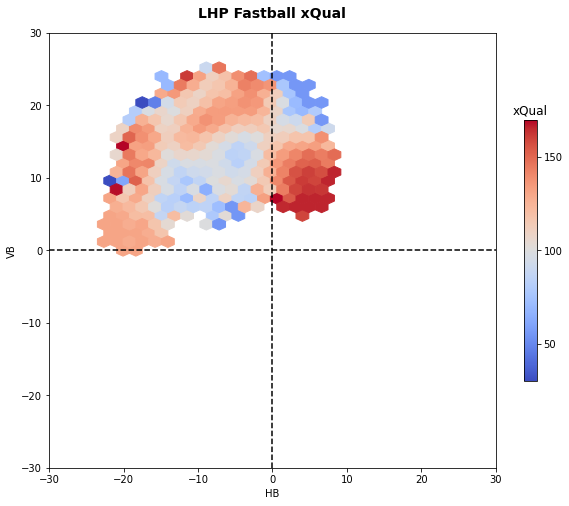

In [15]:
plt.figure(figsize = (10, 8))
plt.hexbin(ff_l_stats['pfx_x'], ff_l_stats['pfx_z'], C = ff_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(ff_l_stats['pfx_x'], ff_l_stats['pfx_z'], C = ff_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Cutter Analysis

In [16]:
fc_stats = xrv.loc[xrv['pitch_type'] == 'FC']
fc_r_stats = fc_stats.loc[fc_stats['p_throws'] == 'R']
fc_l_stats = fc_stats.loc[fc_stats['p_throws'] == 'L']

fc_r_avg = fc_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
fc_l_avg = fc_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
fc_avg = pd.concat([fc_r_avg, fc_l_avg], ignore_index = True)
fc_avg = fc_avg.round(1)
fc_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,FC,R,89.5,2422.6,-3.0,7.9,5.9,6.3
1,FC,L,86.8,2267.2,1.7,7.9,5.8,6.2


In [17]:
fc_stats[['rv', 'xRV']].describe()

,rv,xRV
count,47442.000000,47442.000000
mean,-0.024137,-0.021908
std,0.279081,0.158576
min,-1.920000,-1.256090
25%,-0.060000,-0.063760
50%,-0.034000,-0.023770
75%,0.028000,0.017060
max,3.306000,2.338770


### Top 10 Cutter xQual

In [18]:
fc_stats['RV/100'] = ((fc_stats['rv'] / fc_stats['n_pitches']) * 100)
fc_stats['xRV/100'] = ((fc_stats['xRV'] / fc_stats['n_pitches']) * 100)

cols = list(fc_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
fc_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    fc_stats[col_zscore] = ((fc_stats[col] - fc_stats[col].mean())/ fc_stats[col].std(ddof=0) * -1)

stats = fc_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
fc_stats = pd.merge(fc_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
fc_stats['Qual'] = fc_stats['rv_zscore_y'] + 100
fc_stats['xQual'] = fc_stats['xRV_zscore_y'] + 100
fc_r_stats = fc_stats.loc[fc_stats['p_throws'] == 'R']
fc_l_stats = fc_stats.loc[fc_stats['p_throws'] == 'L']
q_stats = fc_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
fc_leaders = stats.sort_values(by = ['xQual'], ascending = False)
fc_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
31,"Burnes, Corbin",R,FC,1354,95.23,-4.19,11.17,-51.97,-3.84,169.10,-53.53,-3.95,250.49
113,"Lynn, Lance",R,FC,775,88.67,-2.71,4.84,-35.78,-4.62,161.18,-37.23,-4.80,227.73
64,"Garcia, Luis",R,FC,565,86.10,-5.69,5.22,-37.78,-6.69,186.52,-26.89,-4.76,191.52
160,"Quantrill, Cal",R,FC,585,88.42,-2.55,6.18,-23.12,-3.95,132.24,-25.65,-4.38,180.93
9,"Anderson, Tyler",L,FC,702,85.02,2.15,9.75,-36.64,-5.22,170.56,-27.03,-3.85,173.50
38,"Clase, Emmanuel",R,FC,722,100.22,-2.73,10.66,-31.52,-4.37,150.52,-26.35,-3.65,166.41
4,"Alvarado, José",L,FC,170,94.11,1.26,5.10,-14.38,-8.46,136.81,-13.90,-8.18,164.17
23,"Bleier, Richard",L,FC,158,87.25,1.05,5.37,-11.21,-7.09,126.50,-13.07,-8.27,160.57
32,"Burr, Ryan",R,FC,238,86.68,-4.79,-1.13,-15.66,-6.58,135.52,-14.62,-6.14,159.32
35,"Chatwood, Tyler",R,FC,214,88.92,-4.79,0.59,-11.58,-5.41,123.00,-14.08,-6.58,159.22


### RHP Cutter HB & VB

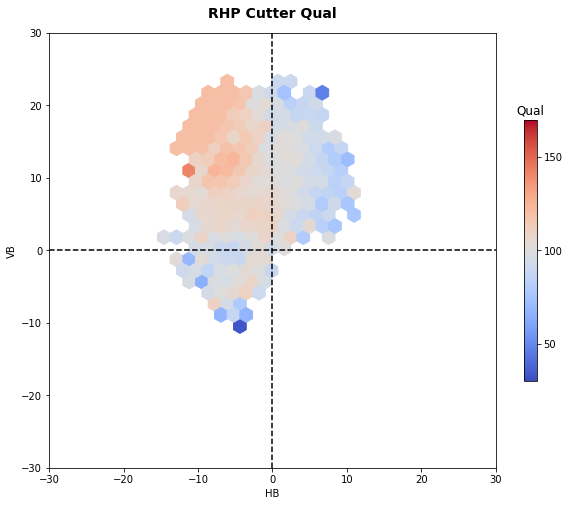

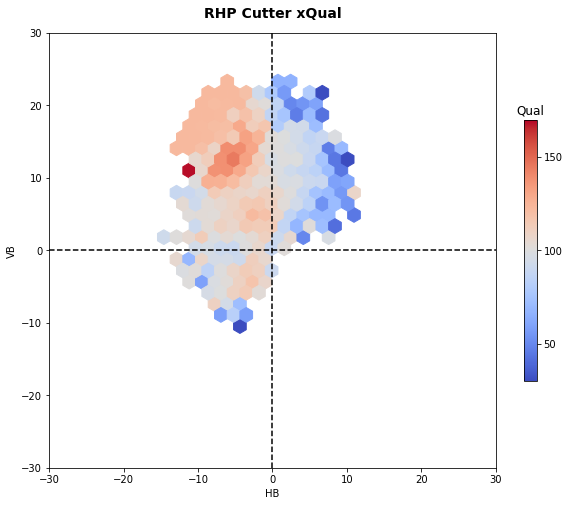

In [19]:
plt.figure(figsize = (10, 8))
plt.hexbin(fc_r_stats['pfx_x'], fc_r_stats['pfx_z'], C =fc_r_stats['Qual'], cmap ='coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Cutter Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fc_r_stats['pfx_x'],fc_r_stats['pfx_z'],C = fc_r_stats['xQual'],cmap = 'coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Cutter xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Cutter HB & VB

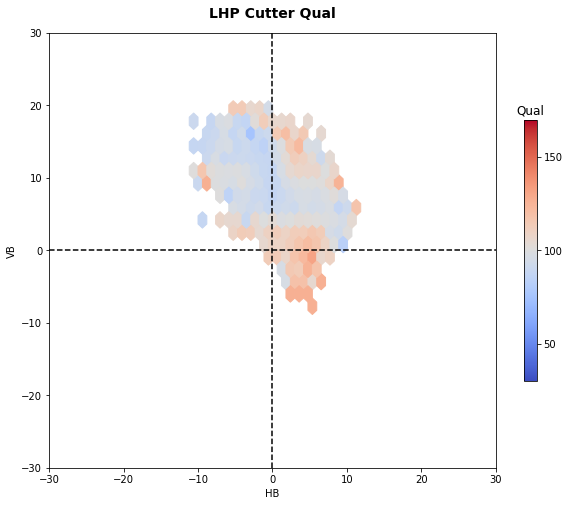

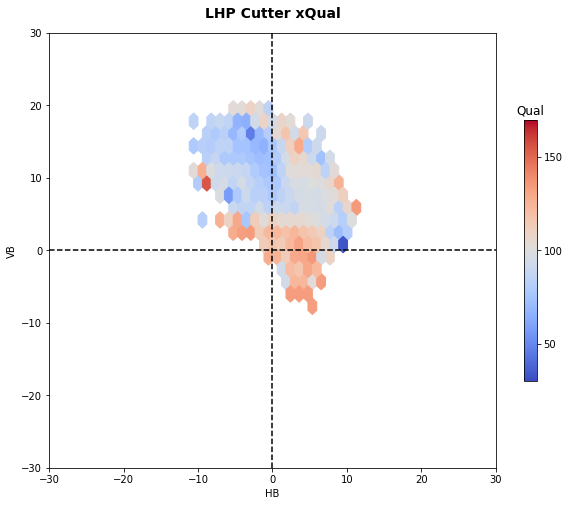

In [20]:
plt.figure(figsize = (10, 8))
plt.hexbin(fc_l_stats['pfx_x'], fc_l_stats['pfx_z'], C = fc_l_stats['Qual'],cmap='coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Cutter Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fc_l_stats['pfx_x'], fc_l_stats['pfx_z'], C = fc_l_stats['xQual'],cmap='coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Cutter xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Sinker Analysis

In [21]:
si_stats = xrv.loc[xrv['pitch_type'] == 'SI']
si_stats = si_stats.round(1)
si_r_stats = si_stats.loc[si_stats['p_throws'] == 'R']
si_l_stats = si_stats.loc[si_stats['p_throws'] == 'L']

si_r_avg = si_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
si_l_avg = si_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
si_avg = pd.concat([si_r_avg, si_l_avg], ignore_index = True)
si_avg = si_avg.round(1)
si_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,SI,R,93.4,2143.9,14.8,9.2,5.7,6.3
1,SI,L,92.1,2077.2,-15.0,9.3,5.8,6.3


In [22]:
si_stats[['rv', 'xRV']].describe()

,rv,xRV
count,109145.000000,109145.000000
mean,-0.016257,-0.012843
std,0.283671,0.162342
min,-1.800000,-1.300000
25%,-0.100000,-0.100000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3.300000,2.300000


### Top 10 Sinker xQual

In [23]:
si_stats['RV/100'] = ((si_stats['rv'] / si_stats['n_pitches']) * 100)
si_stats['xRV/100'] = ((si_stats['xRV'] / si_stats['n_pitches']) * 100)

cols = list(si_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
si_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    si_stats[col_zscore] = ((si_stats[col] - si_stats[col].mean())/ si_stats[col].std(ddof=0) * -1)

stats = si_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
si_stats = pd.merge(si_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
si_stats['Qual'] = si_stats['rv_zscore_y'] + 100
si_stats['xQual'] = si_stats['xRV_zscore_y'] + 100
si_r_stats = si_stats.loc[si_stats['p_throws'] == 'R']
si_l_stats = si_stats.loc[si_stats['p_throws'] == 'L']
q_stats = si_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
si_leaders = stats.sort_values(by = ['xQual'], ascending = False)
si_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
216,"Houser, Adrian",R,SI,1263,93.57,15.95,7.79,-46.0,-3.64,189.78,-54.1,-4.28,333.34
436,"Suárez, Ranger",L,SI,734,92.95,-15.77,7.82,-44.5,-6.06,214.81,-46.0,-6.27,325.29
285,"Matz, Steven",L,SI,1327,94.47,-15.04,12.30,-41.6,-3.13,170.60,-47.3,-3.56,286.39
274,"Manaea, Sean",L,SI,1782,92.14,-13.79,12.28,-66.1,-3.71,230.89,-52.7,-2.96,283.65
262,"Loáisiga, Jonathan",R,SI,595,98.31,15.60,11.78,-33.4,-5.61,183.64,-32.5,-5.46,253.13
484,"Wheeler, Zack",R,SI,580,96.70,15.70,11.43,-30.6,-5.28,174.63,-29.4,-5.07,235.22
473,"Wainwright, Adam",R,SI,860,89.05,12.74,12.29,-44.1,-5.13,206.18,-32.8,-3.81,234.01
7,"Alcantara, Sandy",R,SI,874,97.61,17.27,7.34,-26.6,-3.04,143.68,-32.1,-3.67,228.59
202,"Hendricks, Kyle",R,SI,1187,87.31,13.74,9.21,-30.4,-2.56,139.14,-36.1,-3.04,228.47
178,"Gray, Sonny",R,SI,651,92.42,13.17,9.57,-29.2,-4.49,165.63,-26.8,-4.12,213.59


### RHP Sinker HB & VB

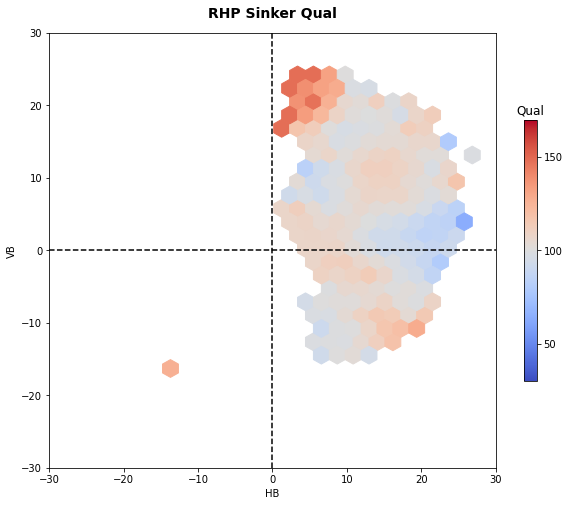

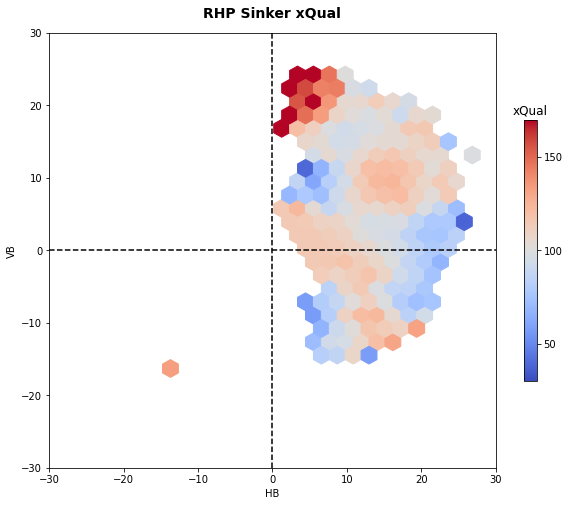

In [24]:
plt.figure(figsize = (10, 8))
plt.hexbin(si_r_stats['pfx_x'], si_r_stats['pfx_z'], C = si_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Sinker Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(si_r_stats['pfx_x'], si_r_stats['pfx_z'], C = si_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Sinker xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Sinker HB & VB

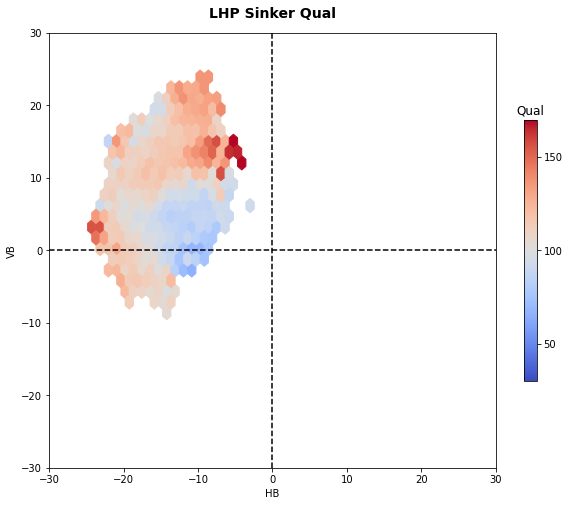

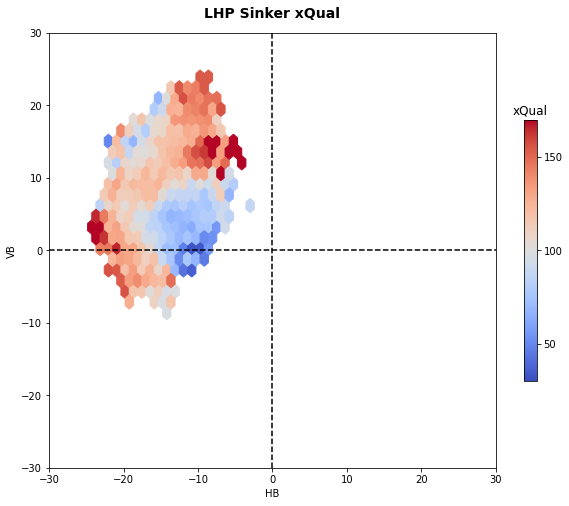

In [25]:
plt.figure(figsize = (10, 8))
plt.hexbin(si_l_stats['pfx_x'], si_l_stats['pfx_z'], C = si_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Sinker Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(si_l_stats['pfx_x'], si_l_stats['pfx_z'], C = si_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Sinker xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Slider Analysis

In [26]:
sl_stats = xrv.loc[xrv['pitch_type'] == 'SL']
sl_r_stats = sl_stats.loc[sl_stats['p_throws'] == 'R']
sl_l_stats = sl_stats.loc[sl_stats['p_throws'] == 'L']

sl_r_avg = sl_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
sl_l_avg = sl_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
sl_avg = pd.concat([sl_r_avg, sl_l_avg], ignore_index = True)
sl_avg = sl_avg.round(1)
sl_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,SL,R,84.9,2438.2,-6.3,1.8,5.8,6.3
1,SL,L,83.9,2357.1,5.8,1.5,5.9,6.2


In [27]:
sl_stats[['rv', 'xRV']].describe()

,rv,xRV
count,135533.000000,135533.000000
mean,-0.040556,-0.039973
std,0.280246,0.158926
min,-1.760000,-1.358070
25%,-0.067000,-0.080310
50%,-0.034000,-0.033150
75%,0.028000,0.006780
max,3.707000,2.366440


### Top 10 Slider xQual

In [28]:
sl_stats['RV/100'] = ((sl_stats['rv'] / sl_stats['n_pitches']) * 100)
sl_stats['xRV/100'] = ((sl_stats['xRV'] / sl_stats['n_pitches']) * 100)

cols = list(sl_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
sl_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    sl_stats[col_zscore] = ((sl_stats[col] - sl_stats[col].mean())/ sl_stats[col].std(ddof=0) * -1)

stats = sl_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
sl_stats = pd.merge(sl_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
sl_stats['Qual'] = sl_stats['rv_zscore_y'] + 100
sl_stats['xQual'] = sl_stats['xRV_zscore_y'] + 100
sl_r_stats = sl_stats.loc[sl_stats['p_throws'] == 'R']
sl_l_stats = sl_stats.loc[sl_stats['p_throws'] == 'L']

q_stats = sl_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
sl_leaders = stats.sort_values(by = ['xQual'], ascending = False)
sl_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
499,"Ray, Robbie",L,SL,964,88.62,0.98,7.16,-57.43,-5.96,165.42,-69.49,-7.21,294.80
516,"Rodón, Carlos",L,SL,603,85.76,8.21,-1.06,-49.04,-8.13,187.72,-51.68,-8.57,273.54
391,"McHugh, Collin",R,SL,514,79.47,-18.72,-0.61,-39.33,-7.65,165.94,-45.64,-8.88,257.91
426,"Musgrove, Joe",R,SL,815,84.07,-14.03,-1.56,-52.88,-6.49,170.76,-54.08,-6.64,235.27
76,"Buehler, Walker",R,SL,433,84.86,-14.19,0.79,-34.94,-8.07,162.00,-36.27,-8.38,219.30
522,"Rogers, Tyler",R,SL,479,71.76,-13.14,13.84,-39.56,-8.26,171.86,-38.05,-7.94,218.94
686,"deGrom, Jacob",R,SL,409,91.57,-4.67,3.46,-35.96,-8.79,169.15,-33.31,-8.14,206.69
78,"Bummer, Aaron",L,SL,281,82.96,17.92,-5.02,-27.84,-9.91,158.69,-28.09,-10.00,206.09
111,"Clase, Emmanuel",R,SL,310,91.85,-6.20,0.81,-25.70,-8.29,146.83,-29.03,-9.36,204.69
387,"McCullers Jr., Lance",R,SL,719,85.99,-13.67,4.59,-39.17,-5.45,135.73,-44.16,-6.14,197.03


### RHP Slider HB & VB

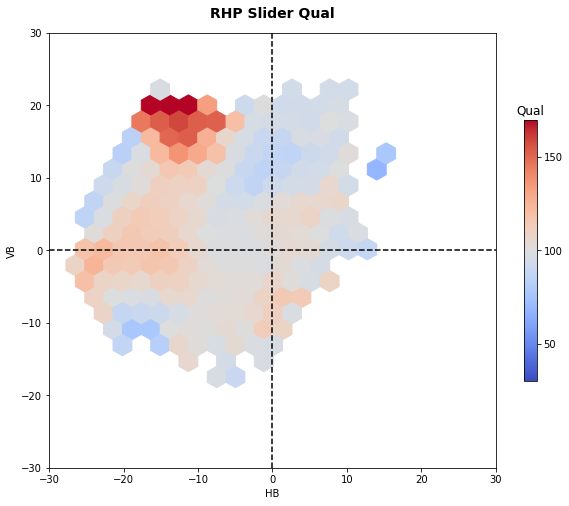

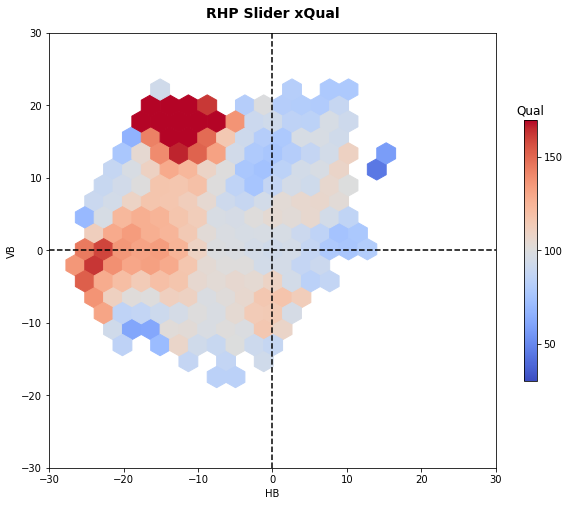

In [29]:
plt.figure(figsize = (10, 8))
plt.hexbin(sl_r_stats['pfx_x'], sl_r_stats['pfx_z'], C = sl_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Slider Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(sl_r_stats['pfx_x'], sl_r_stats['pfx_z'], C = sl_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Slider xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Slider HB & VB

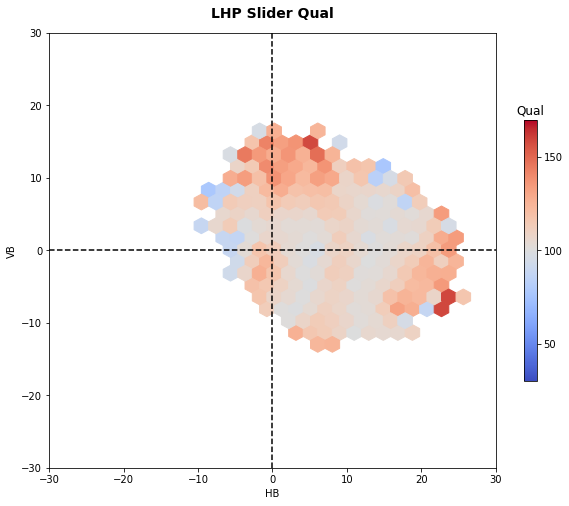

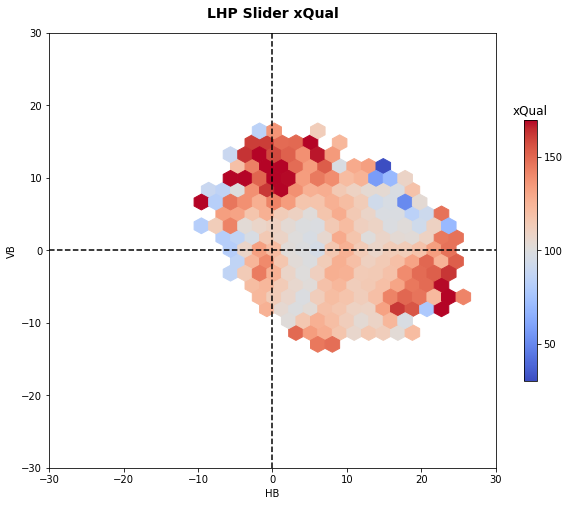

In [30]:
plt.figure(figsize = (10, 8))
plt.hexbin(sl_l_stats['pfx_x'], sl_l_stats['pfx_z'], C = sl_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Slider Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(sl_l_stats['pfx_x'], sl_l_stats['pfx_z'], C = sl_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Slider xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Curveball Analysis

In [31]:
cu_stats = xrv.loc[xrv['pitch_type'] == 'CU']
cu_r_stats = cu_stats.loc[cu_stats['p_throws'] == 'R']
cu_l_stats = cu_stats.loc[cu_stats['p_throws'] == 'L']

cu_r_avg = cu_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
cu_l_avg = cu_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
cu_avg = pd.concat([cu_r_avg, cu_l_avg], ignore_index = True)
cu_avg = cu_avg.round(1)
cu_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,CU,R,79.2,2538.3,-9.6,-9.3,6.0,6.2
1,CU,L,77.7,2439.9,8.4,-7.5,6.0,6.1


In [32]:
cu_stats[['rv', 'xRV']].describe()

,rv,xRV
count,58770.000000,58770.000000
mean,-0.038081,-0.037628
std,0.254521,0.147132
min,-2.012000,-1.172260
25%,-0.053000,-0.073000
50%,-0.034000,-0.028520
75%,0.028000,0.008437
max,3.306000,2.213520


### Top 10 Curveball xQual

In [33]:
cu_stats['RV/100'] = ((cu_stats['rv'] / cu_stats['n_pitches']) * 100)
cu_stats['xRV/100'] = ((cu_stats['xRV'] / cu_stats['n_pitches']) * 100)

cols = list(cu_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
cu_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    cu_stats[col_zscore] = ((cu_stats[col] - cu_stats[col].mean())/ cu_stats[col].std(ddof=0) * -1)

stats = cu_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
cu_stats = pd.merge(cu_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
cu_stats['Qual'] = cu_stats['rv_zscore_y'] + 100
cu_stats['xQual'] = cu_stats['xRV_zscore_y'] + 100
cu_r_stats = cu_stats.loc[cu_stats['p_throws'] == 'R']
cu_l_stats = cu_stats.loc[cu_stats['p_throws'] == 'L']

q_stats = cu_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
cu_leaders = stats.sort_values(by = ['xQual'], ascending = False)
cu_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
293,"Morton, Charlie",R,CU,1095,80.64,-16.57,-10.06,-71.97,-6.57,218.92,-74.34,-6.79,325.19
429,"Urías, Julio",L,CU,952,81.38,15.78,-0.93,-61.65,-6.48,199.77,-62.99,-6.62,284.65
431,"Valdez, Framber",L,CU,643,77.92,13.52,-15.30,-44.32,-6.89,177.92,-49.03,-7.63,268.79
296,"Musgrove, Joe",R,CU,698,82.07,-11.02,-13.68,-41.42,-5.93,158.31,-47.55,-6.81,244.65
147,"Glasnow, Tyler",R,CU,183,83.50,-4.63,-17.54,-24.77,-13.53,169.94,-25.34,-13.85,225.43
287,"Montgomery, Jordan",L,CU,606,79.98,0.95,-3.96,-34.95,-5.77,146.64,-39.87,-6.58,216.01
59,"Burnes, Corbin",R,CU,473,81.20,-11.27,-7.84,-34.67,-7.33,165.44,-34.48,-7.29,213.41
203,"Johnson, Pierce",R,CU,704,84.30,-10.98,-4.92,-40.31,-5.73,153.05,-41.80,-5.94,204.08
266,"McClanahan, Shane",L,CU,321,82.51,6.03,-10.68,-21.28,-6.63,135.58,-25.77,-8.03,193.09
40,"Berríos, José",R,CU,927,82.93,-15.04,-3.52,-50.21,-5.42,158.57,-48.17,-5.20,190.30


### RHP Curveball HB & VB

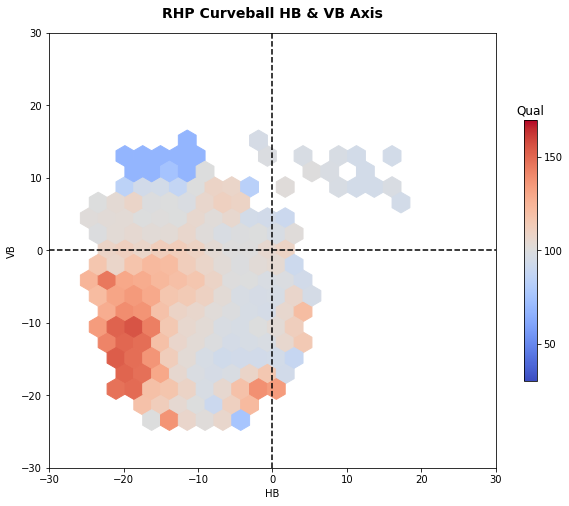

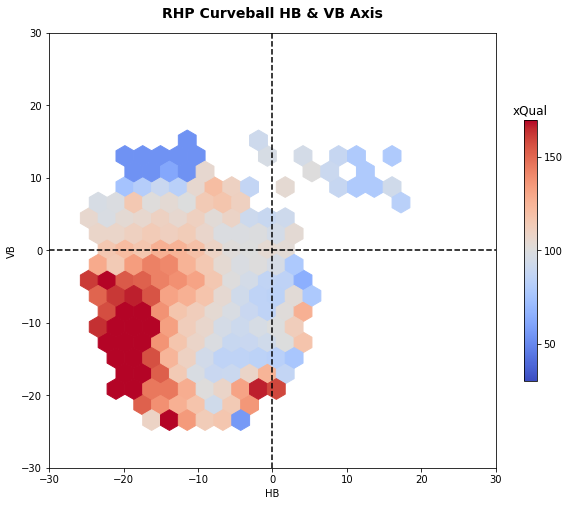

In [34]:
plt.figure(figsize = (10, 8))
plt.hexbin(cu_r_stats['pfx_x'], cu_r_stats['pfx_z'], C = cu_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(cu_r_stats['pfx_x'], cu_r_stats['pfx_z'], C = cu_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Curveball HB & VB

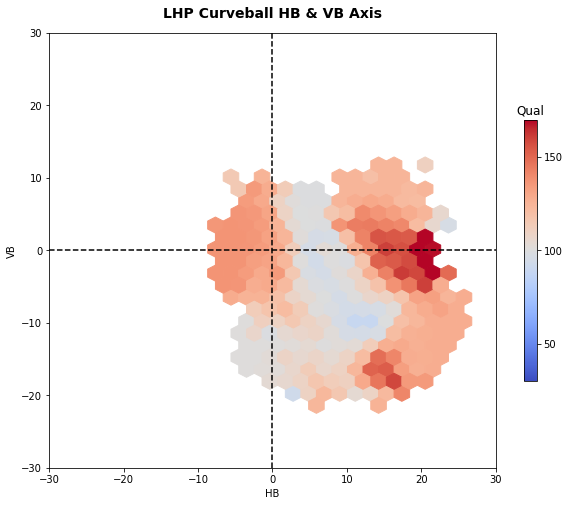

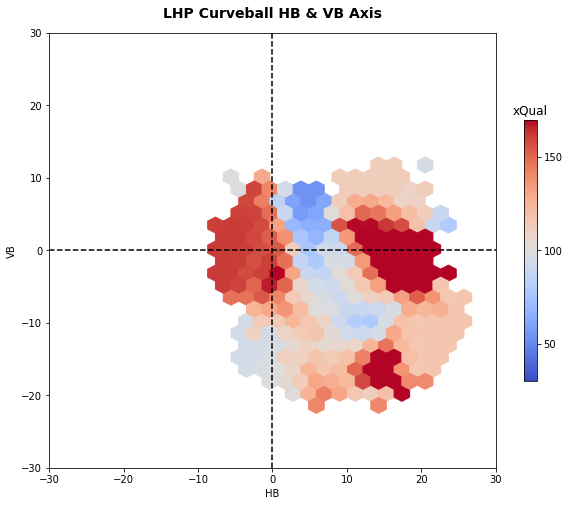

In [35]:
plt.figure(figsize = (10, 8))
plt.hexbin(cu_l_stats['pfx_x'], cu_l_stats['pfx_z'], C = cu_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(cu_l_stats['pfx_x'], cu_l_stats['pfx_z'], C = cu_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Changeup Analysis

In [36]:
ch_stats = xrv.loc[xrv['pitch_type'] == 'CH']
ch_r_stats = ch_stats.loc[ch_stats['p_throws'] == 'R']
ch_l_stats = ch_stats.loc[ch_stats['p_throws'] == 'L']

ch_r_avg = ch_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
ch_l_avg = ch_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
ch_avg = pd.concat([ch_r_avg, ch_l_avg], ignore_index = True)
ch_avg = ch_avg.round(1)
ch_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,CH,R,85.5,1756.8,13.8,6.3,5.8,6.3
1,CH,L,83.6,1737.4,-13.9,7.8,5.8,6.2


In [37]:
ch_stats[['rv', 'xRV']].describe()

,rv,xRV
count,80330.000000,80330.000000
mean,-0.031865,-0.029683
std,0.279578,0.158931
min,-1.770000,-1.084440
25%,-0.067000,-0.073370
50%,-0.034000,-0.025790
75%,0.032000,0.015467
max,3.306000,2.252770


### Top 10 Changeup xQual

In [38]:
ch_stats['RV/100'] = ((ch_stats['rv'] / ch_stats['n_pitches']) * 100)
ch_stats['xRV/100'] = ((ch_stats['xRV'] / ch_stats['n_pitches']) * 100)

cols = list(ch_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
ch_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    ch_stats[col_zscore] = ((ch_stats[col] - ch_stats[col].mean())/ ch_stats[col].std(ddof=0) * -1)

stats = ch_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
ch_stats = pd.merge(ch_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
ch_stats['Qual'] = ch_stats['rv_zscore_y'] + 100
ch_stats['xQual'] = ch_stats['xRV_zscore_y'] + 100
ch_r_stats = ch_stats.loc[ch_stats['p_throws'] == 'R']
ch_l_stats = ch_stats.loc[ch_stats['p_throws'] == 'L']

q_stats = ch_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
ch_leaders = stats.sort_values(by = ['xQual'], ascending = False)
ch_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
101,"Castillo, Luis",R,CH,952,88.33,16.77,0.94,-52.99,-5.57,181.04,-52.43,-5.51,252.11
594,"Urías, Julio",L,CH,483,86.81,-14.58,7.23,-32.74,-6.78,162.06,-35.09,-7.27,230.60
627,"Williams, Devin",R,CH,621,83.72,16.96,-4.16,-35.35,-5.69,155.68,-38.02,-6.12,223.27
11,"Alcantara, Sandy",R,CH,728,91.82,16.07,3.31,-37.98,-5.22,152.86,-40.64,-5.58,219.75
225,"Giolito, Lucas",R,CH,940,81.51,10.20,12.86,-46.40,-4.94,158.81,-45.55,-4.85,211.01
374,"Matz, Steven",L,CH,598,85.05,-15.94,3.27,-35.79,-5.99,159.86,-34.95,-5.84,208.24
519,"Scherzer, Max",R,CH,421,84.98,15.16,3.95,-26.57,-6.31,147.06,-29.59,-7.03,207.58
403,"Montgomery, Jordan",L,CH,626,82.48,-9.74,14.71,-28.15,-4.50,129.33,-34.81,-5.56,202.09
564,"Sulser, Cole",R,CH,355,83.96,13.49,5.60,-32.33,-9.11,175.16,-26.59,-7.49,201.02
359,"López, Pablo",R,CH,542,87.99,17.44,3.03,-28.52,-5.26,140.24,-32.12,-5.93,200.85


### RHP Changeup HB & VB

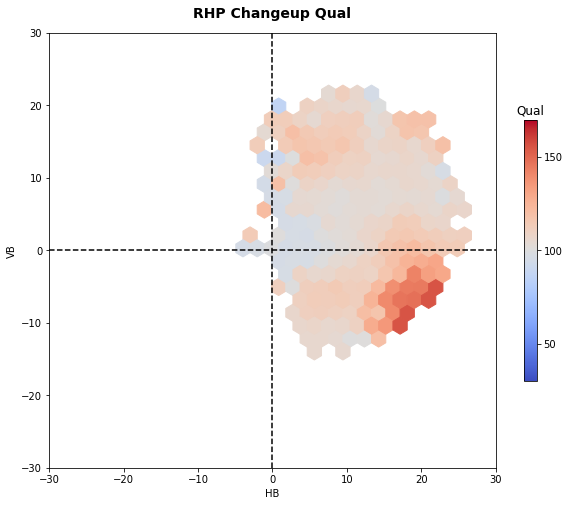

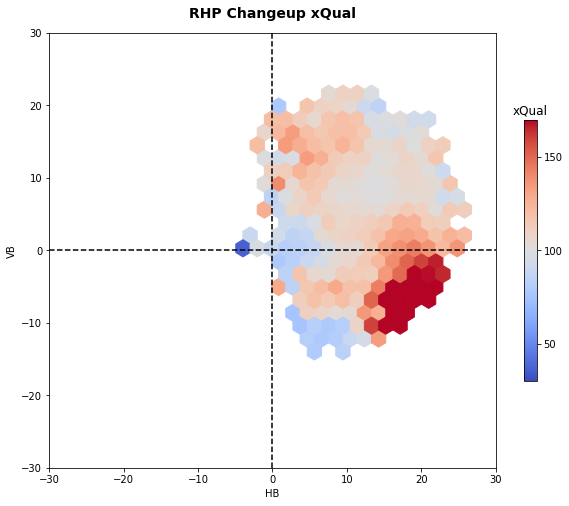

In [39]:
plt.figure(figsize = (10, 8))
plt.hexbin(ch_r_stats['pfx_x'], ch_r_stats['pfx_z'], C = ch_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Changeup Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(ch_r_stats['pfx_x'], ch_r_stats['pfx_z'], C = ch_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Changeup xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Changeup HB & VB

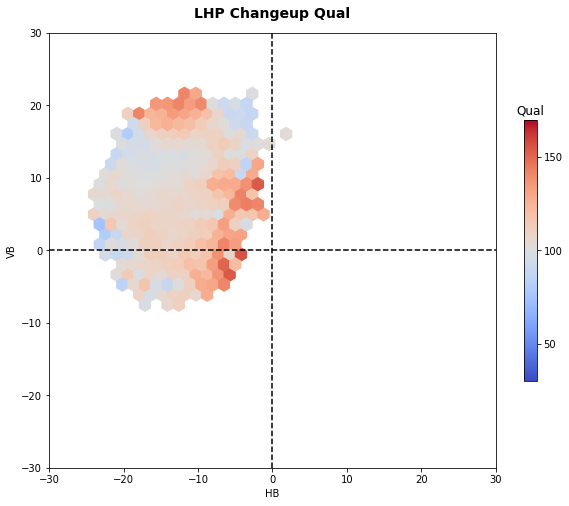

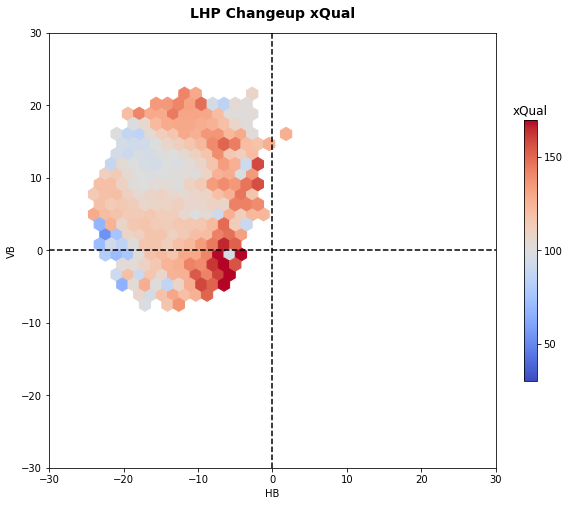

In [40]:
plt.figure(figsize = (10, 8))
plt.hexbin(ch_l_stats['pfx_x'], ch_l_stats['pfx_z'], C = ch_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Changeup Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(ch_l_stats['pfx_x'], ch_l_stats['pfx_z'], C = ch_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Changeup xQual', fontsize = 14, fontweight = 'bold', pad = 15);